# COVID

2019 Novel Coronavirus (2019-nCoV) is a virus (more specifically, a coronavirus) identified as the cause of an outbreak of respiratory illness first detected in Wuhan, China. Early on, many of the patients in the outbreak in Wuhan, China reportedly had some link to a large seafood and animal market, suggesting animal-to-person spread. However, a growing number of patients reportedly have not had exposure to animal markets, indicating person-to-person spread is occurring. At this time, it’s unclear how easily or sustainably this virus is spreading between people - CDC

This dataset has daily level information on the number of affected cases, deaths and recovery from 2019 novel coronavirus. Please note that this is a time series data and so the number of cases on any given day is the cumulative number.

The data is available from 22 Jan, 2020.

In [1]:
# import libraries
import pandas as pd
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf

# RUN THIS CELL
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import the dataset from Kaggle, located here: https://www.kaggle.com/abhinand05/covid-19-digging-a-bit-deeper

df = pd.read_csv('covid_19_data.csv', index_col=0)
df.index.name=None
df.reset_index(inplace=True)

In [3]:
df.head()

,index,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


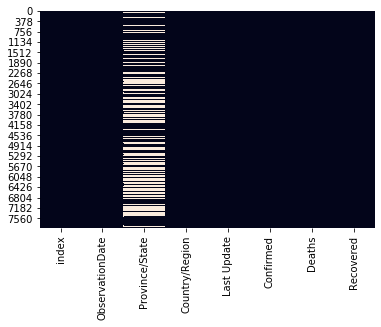

In [4]:
sns.heatmap(df.isnull(), cbar=False)

In [5]:
df.drop(columns = ['Province/State'], inplace = True)

In [14]:
df.columns

Index(['index', 'ObservationDate', 'Country/Region', 'Last Update',
       'Confirmed', 'Deaths', 'Recovered'],
      dtype='object')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7926 entries, 0 to 7925
Data columns (total 7 columns):
index              7926 non-null int64
ObservationDate    7926 non-null object
Country/Region     7926 non-null object
Last Update        7926 non-null object
Confirmed          7926 non-null float64
Deaths             7926 non-null float64
Recovered          7926 non-null float64
dtypes: float64(3), int64(1), object(3)
memory usage: 433.6+ KB


In [32]:
df['ObservationDate'] = pd.to_datetime(df['ObservationDate'])
df.set_index(['ObservationDate'], inplace=True)
df.index.name=None
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7926 entries, 2020-01-22 to 2020-03-22
Data columns (total 5 columns):
Country/Region    7926 non-null object
Last Update       7926 non-null object
Confirmed         7926 non-null float64
Deaths            7926 non-null float64
Recovered         7926 non-null float64
dtypes: float64(3), object(2)
memory usage: 371.5+ KB


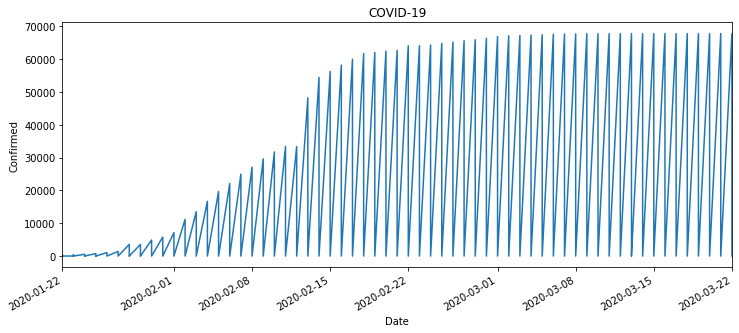

In [33]:
title='COVID-19'
ylabel='Confirmed'
xlabel='Date'

ax = df['Confirmed'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

<Figure size 432x288 with 0 Axes>

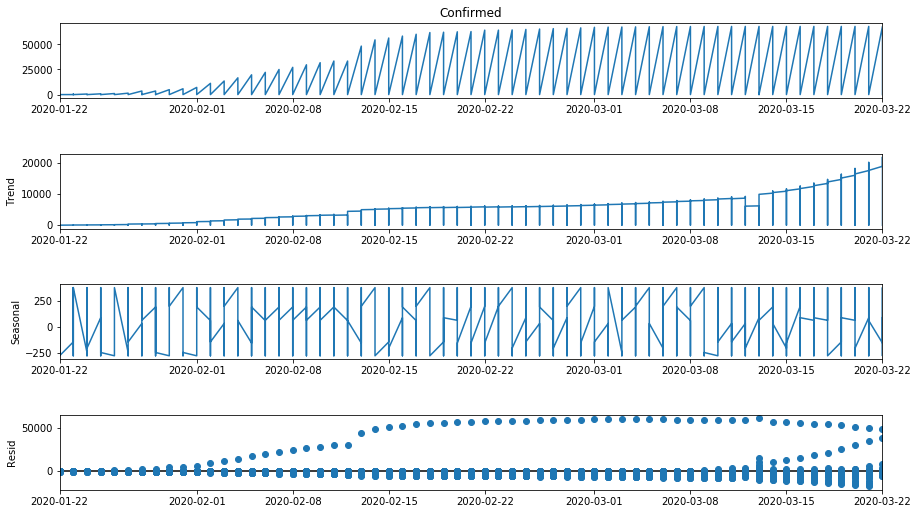

In [35]:
decomposition = seasonal_decompose(df['Confirmed'], freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [39]:
auto_arima(df['Confirmed'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7926
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -78448.983
Date:                Wed, 25 Mar 2020   AIC                         156909.965
Time:                        11:40:14   BIC                         156951.832
Sample:                             0   HQIC                        156924.302
                               - 7926                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    400.6430    257.536      1.556      0.120    -104.118     905.404
ar.L1         -0.1183      1.057     -0.112      0.911      -2.191       1.954
ar.L2          0.5627      0.707      0.796      0.426      -0.824       1.949
ma.L1          0.3129      1.057      0.296      0.767      -1.759       2.385
ma.L2         -0.4164      0.499     -0.834      0.404      -1.395       0.563
sigma2      2.316e+07      0.312   7.42e+07      0.000    2.32e+07    2.32e+07
===================================================================================
Ljung-Box (Q):                        5.25   Jarque-Bera (JB):           9101669.04
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                            12.51
Prob(H) (two-sided):                  0.00   Kurtosis:                       167.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.26e+22. Standard errors may be unstable.
"""

AttributeError: 'DataFrame' object has no attribute 'seasonal_first_difference'

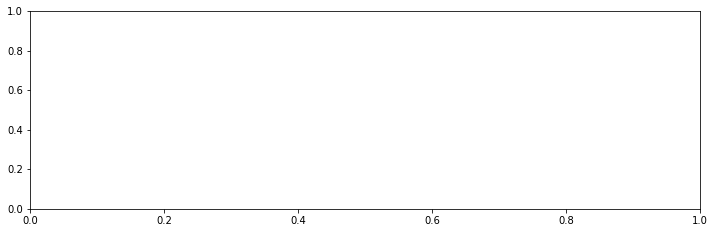

In [37]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.seasonal_first_difference.iloc[13:], lags=40, ax=ax2)

In [38]:
mod = sm.tsa.statespace.SARIMAX(df['Confirmed'], trend='n', order=(0,1,0), seasonal_order=(0,1,1,12))
results = mod.fit()
print results.summary()

SyntaxError: invalid syntax (<ipython-input-38-14758790e274>, line 3)

In [ ]:
Hyperparameter Tuning

In [ ]:
X = df.drop(['Attrition'],axis=1)
y = df['Attrition']

sns.set(style="whitegrid", palette=("deep"),font='calibri')
sns.set_context("poster")

X.corrwith(df['Attrition']).plot.bar(figsize = (20, 10), title ="Correlation with Attrition", fontsize = 10,
rot = 90, grid = True,)

sns.palplot(sns.color_palette())